In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans, MeanShift
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold, train_test_split

from joblib import Parallel, delayed

import warnings
from tqdm import tqdm
import os

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

## Load data
path_clean = 'https://raw.githubusercontent.com/Socrano/ACTU-Project/main/df_clean.csv'
path_std_onehot = 'https://raw.githubusercontent.com/Socrano/ACTU-Project/main/df_std_onehot.csv'
path_cluster_label = 'https://raw.githubusercontent.com/Socrano/ACTU-Project/main/df_with_class_std.csv'
# path_std_numOnly = '...'
# path_pca = '...'

df_std_onehot = pd.read_csv(path_std_onehot)
print('\n================================== standardized data with OneHot encoding ==================================')
display(df_std_onehot.head())

df_with_class_std = pd.read_csv(path_cluster_label)
print('\n================================== standardized data with cluster labels ==================================')
display(df_with_class_std.head())

df_clean= pd.read_csv(path_clean,index_col=0)
df_clean.loc[:, 'payment_date'] = df_clean['payment_date'].astype('datetime64[ns]')
# df_clean=df_clean.reindex_like(df_std_onehot)
print('================================== cleaned data ==================================')
display(df_clean.head())

## List of property_types and incident_types. Might be useful.
prop_type=df_clean['property_type'].unique().tolist()
inci_type=df_clean['incident_type'].unique().tolist()
incident_types_by_property = df_clean.groupby('property_type')['incident_type'].unique().reset_index()
df_clean=df_clean.reset_index(drop=True)
policy_features=['house', 'apartment', 'townhouse', 'shop', 'department store', 'factory', 'warehouse', 'sedan', 'SUV', 'sports car', 'marine cargo', 'turboprop aircraft', 'light sport aircraft', 'property_value', 'pml', 'deductible']



================================== standardized data with OneHot encoding ==================================


,house,apartment,townhouse,shop,department store,factory,warehouse,sedan,SUV,sports car,...,claim_amount,pml,deductible,payment,water damage,theft,nat cat,fire,other,collision
0,1,0,0,0,0,0,0,0,0,0,...,-0.069061,-0.158192,0.009751,-0.049049,1,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,-0.072354,-0.155793,-0.153713,-0.118216,0,1,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,-0.065496,-0.237351,-0.112847,-0.043878,0,0,1,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,-0.065800,-0.215762,-0.174146,-0.043612,0,0,0,1,0,0
4,1,0,0,0,0,0,0,0,0,0,...,-0.065061,-0.278130,0.009751,-0.044603,0,0,0,0,1,0



================================== standardized data with cluster labels ==================================


,house,apartment,townhouse,shop,department store,factory,warehouse,sedan,SUV,sports car,...,deductible,payment,water damage,theft,nat cat,fire,other,collision,cluster_km,cluster_ms
0,1,0,0,0,0,0,0,0,0,0,...,0.009751,-0.049049,1,0,0,0,0,0,2,0
1,1,0,0,0,0,0,0,0,0,0,...,-0.153713,-0.118216,0,1,0,0,0,0,2,0
2,1,0,0,0,0,0,0,0,0,0,...,-0.112847,-0.043878,0,0,1,0,0,0,2,0
3,1,0,0,0,0,0,0,0,0,0,...,-0.174146,-0.043612,0,0,0,1,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0.009751,-0.044603,0,0,0,0,1,0,2,0


================================== cleaned data ==================================


,property_type,claim_amount,property_value,pml,deductible,claim_status,payment,incident_date,payment_date,incident_type,category
0,house,196740.0,528000.0,106000.0,5000.0,settled,191740,2007-07-02,2007-09-30 00:00:00,water damage,residential
1,house,187650.0,533000.0,107000.0,1000.0,open,20000,2011-04-03,2011-07-02 00:00:00,theft,residential
2,house,206580.0,366000.0,73000.0,2000.0,settled,204580,2019-01-12,2019-04-12 00:00:00,nat cat,residential
4,house,205740.0,411000.0,82000.0,500.0,settled,205240,2023-05-21,2023-08-19 00:00:00,fire,residential
5,house,207780.0,278000.0,56000.0,5000.0,settled,202780,2016-12-16,2017-03-16 00:00:00,other,residential


,Y1,Y2,Y3,Y4
0.00,-0.0000,-0.0000,0.0000,0.0000
0.01,0.0275,0.0410,0.0922,0.1870
0.02,0.0529,0.0766,0.1569,0.2806
0.03,0.0765,0.1081,0.2070,0.3436
0.04,0.0986,0.1365,0.2479,0.3912
...,...,...,...,...
0.96,0.9727,0.9769,0.9848,0.9917
0.97,0.9796,0.9827,0.9887,0.9938
0.98,0.9864,0.9885,0.9925,0.9959
0.99,0.9932,0.9942,0.9962,0.9980


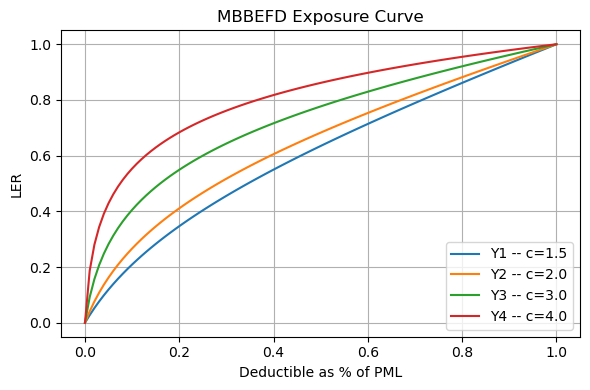

In [12]:
def swissRe(c):
    """
    Input: c (1.5, 2, 3, 4, 5)
    Returns: (b, g) parameters for the MBBEFD curves Y1, Y2, Y3, Y4, and Lloyd's curve
    """
    b = np.exp(3.1-0.15*(1+c)*c)
    g = np.exp((0.78+0.12*c)*c)
    
    return b, g

def MBBEFD(x, b, g):
    if g==1 or b==0:
        return x
    if b==1 and g>1:
        return np.log(1+(g-1)*x)/np.log(g)
    if b*g==1 and g>1:
        return (1-b**x)/(1-b)
    if b>0 and b!=1 and b*g!=1 and g>1:
        return np.log(((g-1)*b+(1-g*b)*(b**x))/(1-b))/np.log(g*b)
    return "Error. Please check input b and g."

# Define a range of c values (deductible as % of PML)
c_values = np.array([1.5, 2, 3, 4, 5])
curve_names=[f'Y{i}' for i in range(1,6)]

x=np.linspace(0,1,101)
curves={}
for c in c_values[:-1]:
    b, g = swissRe(c)
    y=MBBEFD(x, b, g)
    curves[c]=y

curves=pd.DataFrame(curves,index=x)
curves.columns=curve_names[:-1]
display(curves.round(4))

# Plot b and g parameters
plt.figure(figsize=(6,4))
plt.subplot()
plt.title('MBBEFD Exposure Curve')
plt.plot(curves)
plt.xlabel('Deductible as % of PML')
plt.ylabel('LER')
plt.legend([f'Y{i+1} -- c={c_values[i]}' for i in range(5)])
plt.grid(True)

plt.tight_layout()
plt.show()

,house,apartment,townhouse,shop,department store,factory,warehouse,sedan,SUV,sports car,marine cargo,turboprop aircraft,light sport aircraft,property_value,pml,deductible,cv
0,1,0,0,0,0,0,0,0,0,0,0,0,0,-0.078419,-0.158192,0.009751,0.070653
1,1,0,0,0,0,0,0,0,0,0,0,0,0,-0.074858,-0.155793,-0.153713,0.070653
2,1,0,0,0,0,0,0,0,0,0,0,0,0,-0.193779,-0.237351,-0.112847,0.070653
3,1,0,0,0,0,0,0,0,0,0,0,0,0,-0.161734,-0.215762,-0.174146,0.070653
4,1,0,0,0,0,0,0,0,0,0,0,0,0,-0.256444,-0.278130,0.009751,0.070653
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16900,0,0,0,0,0,0,0,0,0,0,0,0,1,1.009671,4.519408,4.014610,0.698640
16901,0,0,0,0,0,0,0,0,0,0,0,0,1,5.477391,19.569284,16.805642,0.698640
16902,0,0,0,0,0,0,0,0,0,0,0,0,1,1.103669,4.836045,4.259806,0.698640
16903,0,0,0,0,0,0,0,0,0,0,0,0,1,1.992370,7.829709,6.834359,0.698640


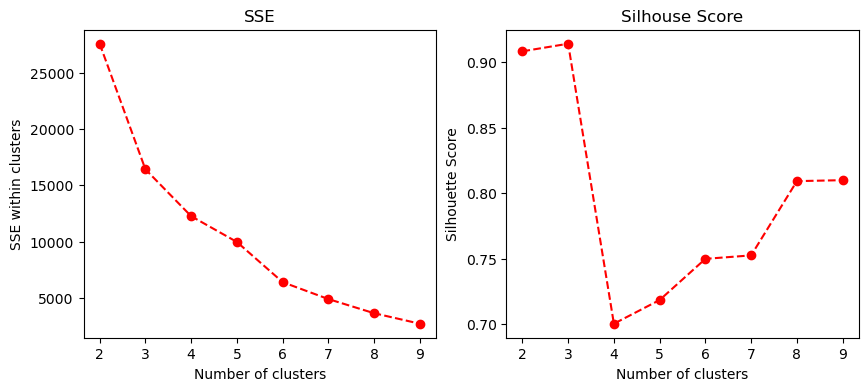

In [3]:
df=df_std_onehot.loc[:,policy_features].copy()
df['cv']=df_clean.groupby('property_type')['claim_amount'].transform(lambda x: x.std() / x.mean()).values
display(df)
sse = {}
sc = {}

for k in range(2, 10):
    kmeans = KMeans(n_init=3,n_clusters=k, random_state=1).fit(df)
    sse[k] = kmeans.inertia_
    labels = kmeans.predict(df)
    sc[k] = silhouette_score(df, labels)

#Elbow plot
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.title("SSE")
plt.plot(list(sse.keys()), list(sse.values()), 'ro--')
plt.xlabel("Number of clusters")
plt.ylabel("SSE within clusters")

# Silhouette plot
plt.subplot(122)
plt.title("Silhouse Score")
plt.plot(list(sc.keys()), list(sc.values()), 'ro--')
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette Score")
plt.show()

## Make Labels

In [4]:
## ---------------------------------------- K=3 ---------------------------------------- ##
kmeans_3K = KMeans(n_init=3,n_clusters=3, random_state=1).fit(df)
labels_3K = kmeans_3K.predict(df)
df_3K=df_clean[['property_value','pml','deductible','claim_amount','payment']].copy()
df_3K['label_3K']=labels_3K

## ---------------------------------------- K=4 ---------------------------------------- ##
kmeans_4K = KMeans(n_init=3,n_clusters=4, random_state=1).fit(df)
labels_4K = kmeans_4K.predict(df)
df_4K=df_clean[['property_value','pml','deductible','claim_amount','payment']].copy()

df_4K['label_4K']=labels_4K

In [5]:
## ---------------------------------------- K=3 ---------------------------------------- ##
cluster_info_3K=[]
for i in range(3):
    info={}
    info['count']=len(df_3K[df_3K.label_3K==i])
    info['claim_amount_mean']=df_3K[df_3K.label_3K==i]['claim_amount'].mean()
    info['claim_amount_cv']=info['claim_amount_mean']/df_3K[df_3K.label_3K==i]['claim_amount'].std()
    info['pml_mean']=df_3K[df_3K.label_3K==i]['pml'].mean()
    info['pml_cv']=info['pml_mean']/df_3K[df_3K.label_3K==i]['pml'].std()
    # info['ded_mean']=df_3K[df_3K.label_3K==i]['deductible'].mean()
    # info['ded_cv']=info['ded_mean']/df_3K[df_3K.label_3K==i]['deductible'].std()
    # info['payment_mean']=df_3K[df_3K.label_3K==i]['payment'].mean()
    # info['payment_cv']=info['payment_mean']/df_3K[df_3K.label_3K==i]['payment'].std()
    # info[]
    cluster_info_3K.append(info)
cluster_info_3K=pd.DataFrame(cluster_info_3K, index=range(3)).round(2)
display("---------------------------------------- K=3 ----------------------------------------",cluster_info_3K)
## ---------------------------------------- K=4 ---------------------------------------- ##
cluster_info_4K=[]
for i in range(4):
    info={}
    info['count']=len(df_4K[df_4K.label_4K==i])
    info['claim_amount_mean']=df_4K[df_4K.label_4K==i]['claim_amount'].mean()
    info['claim_amount_cv']=info['claim_amount_mean']/df_4K[df_4K.label_4K==i]['claim_amount'].std()
    info['pml_mean']=df_4K[df_4K.label_4K==i]['pml'].mean()
    info['pml_cv']=info['pml_mean']/df_4K[df_4K.label_4K==i]['pml'].std()
    # info['ded_mean']=df_4K[df_4K.label_4K==i]['deductible'].mean()
    # info['ded_cv']=info['ded_mean']/df_4K[df_4K.label_4K==i]['deductible'].std()
    # info['payment_mean']=df_4K[df_4K.label_4K==i]['payment'].mean()
    # info['payment_cv']=info['payment_mean']/df_4K[df_4K.label_4K==i]['payment'].std()
    # info[]
    cluster_info_4K.append(info)
cluster_info_4K=pd.DataFrame(cluster_info_4K, index=range(4)).round(2)
display("---------------------------------------- K=4 ----------------------------------------",cluster_info_4K)

'---------------------------------------- K=3 ----------------------------------------'

,count,claim_amount_mean,claim_amount_cv,pml_mean,pml_cv
0,16481,302804.66,0.11,118638.35,0.77
1,240,745150.42,23.44,2327800.00,77.38
2,184,7494641.85,1.44,2134858.70,1.11


'---------------------------------------- K=4 ----------------------------------------'

,count,claim_amount_mean,claim_amount_cv,pml_mean,pml_cv
0,12414,199862.26,14.15,86438.46,3.03
1,240,745150.42,23.44,2327800.00,77.38
2,4067,617023.23,0.12,216924.44,0.76
3,184,7494641.85,1.44,2134858.70,1.11


At a Given Deductible Level:
> `Higher LER`: Indicates that a greater portion of potential losses are eliminated by the deductible, implying that the remaining risk after applying the deductible is lower.
>
> `Lower LER:` Indicates that a smaller portion of potential losses are eliminated by the deductible, implying that more losses are retained. 

Thus, a __higher LER__ suggests __lower risk__ for the insurer at that deductible level. We assign the risk curves as following:

In [6]:
df_3K['curve']=df_3K['label_3K'].replace({0:"Y2",1:"Y1",2:"Y3"})
# df_3K['c_value']=c_values[df_3K.label_3K]
df_3K['ded%']=df_3K['deductible']/df_3K['pml']
cluster_info_3K['curve']=['Y2','Y1','Y3']
display("---------------------------------------- K=3 ----------------------------------------",cluster_info_3K)
df_4K['curve']=df_4K['label_4K'].replace({0:"Y2",1:"Y1",2:"Y4",3:"Y3"})
# df_4K['c_value']=c_values[df_4K.label_4K]
df_4K['ded%']=df_4K['deductible']/df_4K['pml']
cluster_info_4K['curve']=['Y2','Y1','Y4','Y3']
display("---------------------------------------- K=4 ----------------------------------------",cluster_info_4K)



'---------------------------------------- K=3 ----------------------------------------'

,count,claim_amount_mean,claim_amount_cv,pml_mean,pml_cv,curve
0,16481,302804.66,0.11,118638.35,0.77,Y2
1,240,745150.42,23.44,2327800.00,77.38,Y1
2,184,7494641.85,1.44,2134858.70,1.11,Y3


'---------------------------------------- K=4 ----------------------------------------'

,count,claim_amount_mean,claim_amount_cv,pml_mean,pml_cv,curve
0,12414,199862.26,14.15,86438.46,3.03,Y2
1,240,745150.42,23.44,2327800.00,77.38,Y1
2,4067,617023.23,0.12,216924.44,0.76,Y4
3,184,7494641.85,1.44,2134858.70,1.11,Y3


## Pricing

In [7]:
LER=pd.Series([np.nan])
for i in range(3):
    c=c_values[i]
    b, g = swissRe(c)
    LER=pd.concat([LER,MBBEFD(df_3K[df_3K.label_3K==i]['ded%'], b, g).dropna()],axis=0)  
df_3K['LER']=LER.sort_index().dropna()
df_3K['XL']=df_3K['pml']*(1-df_3K['LER'])
display("---------------------------------------- K=3 ----------------------------------------",df_3K.round(3))

LER=pd.Series([np.nan])
for i in range(4):
    c=c_values[i]
    b, g = swissRe(c)
    LER=pd.concat([LER,MBBEFD(df_4K[df_4K.label_4K==i]['ded%'], b, g).dropna()],axis=0)  
df_4K['LER']=LER.sort_index().dropna()
df_4K['XL']=df_4K['pml']*(1-df_4K['LER'])
display("---------------------------------------- K=4 ----------------------------------------",df_4K.round(3))

'---------------------------------------- K=3 ----------------------------------------'

,property_value,pml,deductible,claim_amount,payment,label_3K,curve,ded%,LER,XL
0,528000.0,106000.0,5000.0,196740.0,191740,0,Y2,0.047,0.114,93947.932
1,533000.0,107000.0,1000.0,187650.0,20000,0,Y2,0.009,0.026,104242.901
2,366000.0,73000.0,2000.0,206580.0,204580,0,Y2,0.027,0.071,67852.193
3,411000.0,82000.0,500.0,205740.0,205240,0,Y2,0.006,0.017,80602.758
4,278000.0,56000.0,5000.0,207780.0,202780,0,Y2,0.089,0.192,45265.117
...,...,...,...,...,...,...,...,...,...,...
16900,2056000.0,2056000.0,103000.0,2056500.0,1953500,2,Y3,0.050,0.283,1474185.342
16901,8330000.0,8330000.0,416000.0,8330500.0,7914500,2,Y3,0.050,0.282,5976968.263
16902,2188000.0,2188000.0,109000.0,2188000.0,2079000,2,Y3,0.050,0.282,1570808.378
16903,3436000.0,3436000.0,172000.0,3435500.0,3263500,2,Y3,0.050,0.283,2464100.030


'---------------------------------------- K=4 ----------------------------------------'

,property_value,pml,deductible,claim_amount,payment,label_4K,curve,ded%,LER,XL
0,528000.0,106000.0,5000.0,196740.0,191740,0,Y2,0.047,0.114,93947.932
1,533000.0,107000.0,1000.0,187650.0,20000,0,Y2,0.009,0.026,104242.901
2,366000.0,73000.0,2000.0,206580.0,204580,0,Y2,0.027,0.071,67852.193
3,411000.0,82000.0,500.0,205740.0,205240,0,Y2,0.006,0.017,80602.758
4,278000.0,56000.0,5000.0,207780.0,202780,0,Y2,0.089,0.192,45265.117
...,...,...,...,...,...,...,...,...,...,...
16900,2056000.0,2056000.0,103000.0,2056500.0,1953500,3,Y3,0.050,0.430,1172490.251
16901,8330000.0,8330000.0,416000.0,8330500.0,7914500,3,Y3,0.050,0.429,4754957.781
16902,2188000.0,2188000.0,109000.0,2188000.0,2079000,3,Y3,0.050,0.429,1249896.019
16903,3436000.0,3436000.0,172000.0,3435500.0,3263500,3,Y3,0.050,0.430,1959938.397


In [8]:
df_3K

,property_value,pml,deductible,claim_amount,payment,label_3K,curve,ded%,LER,XL
0,528000.0,106000.0,5000.0,196740.0,191740,0,Y2,0.047170,0.113699,9.394793e+04
1,533000.0,107000.0,1000.0,187650.0,20000,0,Y2,0.009346,0.025767,1.042429e+05
2,366000.0,73000.0,2000.0,206580.0,204580,0,Y2,0.027397,0.070518,6.785219e+04
3,411000.0,82000.0,500.0,205740.0,205240,0,Y2,0.006098,0.017040,8.060276e+04
4,278000.0,56000.0,5000.0,207780.0,202780,0,Y2,0.089286,0.191694,4.526512e+04
...,...,...,...,...,...,...,...,...,...,...
16900,2056000.0,2056000.0,103000.0,2056500.0,1953500,2,Y3,0.050097,0.282984,1.474185e+06
16901,8330000.0,8330000.0,416000.0,8330500.0,7914500,2,Y3,0.049940,0.282477,5.976968e+06
16902,2188000.0,2188000.0,109000.0,2188000.0,2079000,2,Y3,0.049817,0.282080,1.570808e+06
16903,3436000.0,3436000.0,172000.0,3435500.0,3263500,2,Y3,0.050058,0.282858,2.464100e+06


In [9]:
len(df_3K[df_3K.label_3K==1]['ded%'])

240

In [10]:
df_3K.label_3K

0        0
1        0
2        0
3        0
4        0
        ..
16900    2
16901    2
16902    2
16903    2
16904    2
Name: label_3K, Length: 16905, dtype: int32